[Apache Spark](https://spark.apache.org/) es un motor de procesamiento y análisis de datos distribuidos de propósito general.

Spark puede utilizarse en modo autónomo o utilizando gestores de recursos externos como YARN, Kubernetes o Mesos.

Spark trabaja sobre el concepto de RDDs (conjuntos de datos distribuidos resistentes) que representa los datos como una colección distribuida.

El motor de Spark puede aplicar operaciones para consultar y transformar el conjunto de datos en paralelo sobre múltiples ejecutores de Spark.

Los DataFrames son una extensión de los RDD que impone un esquema a la colección distribuida de datos. Los dataframes pueden definirse para consumir desde múltiples fuentes de datos, incluyendo archivos, bases de datos relacionales, bases de datos NoSQL, flujos, etc.



# Instalación y Monitorización


## Instalación

En primer lugar instalamos y configuramos todas las dependencias de Spark para Python. De esta forma enlazaremos nuestro entorno con el servidor de Spark. Además configuraremos el entorno Spark con las variables que sean necestarias.

**NOTA: la última versión de PySpark es la 3.5.1 [link](https://pypi.org/project/pyspark/#history)**

1. Descargar y localizar en `/usr/local/`

In [1]:
!wget -q https://dlcdn.apache.org/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz
!tar xf spark-3.5.1-bin-hadoop3.tgz
!mv  spark-3.5.1-bin-hadoop3 /usr/local/

In [3]:
%%bash
wget http://ftp.ntu.edu.tw/MySQL/Downloads/Connector-J/mysql-connector-java-5.1.49.tar.gz
tar -zxf mysql-connector-java-5.1.49.tar.gz
cd mysql-connector-java-5.1.49
mv mysql-connector-java-5.1.49-bin.jar /usr/local/spark-3.5.1-bin-hadoop3/jars


--2024-02-23 12:40:59--  http://ftp.ntu.edu.tw/MySQL/Downloads/Connector-J/mysql-connector-java-5.1.49.tar.gz
Resolving ftp.ntu.edu.tw (ftp.ntu.edu.tw)... 140.112.36.185
Connecting to ftp.ntu.edu.tw (ftp.ntu.edu.tw)|140.112.36.185|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3362563 (3.2M) [application/octet-stream]
Saving to: ‘mysql-connector-java-5.1.49.tar.gz.1’

     0K .......... .......... .......... .......... ..........  1%  309K 10s
    50K .......... .......... .......... .......... ..........  3% 46.5M 5s
   100K .......... .......... .......... .......... ..........  4%  309K 7s
   150K .......... .......... .......... .......... ..........  6%  309K 8s
   200K .......... .......... .......... .......... ..........  7%  309K 8s
   250K .......... .......... .......... .......... ..........  9% 91.5M 6s
   300K .......... .......... .......... .......... .......... 10%  310K 7s
   350K .......... .......... .......... .......... .......... 12% 58.

2. Establecer las variables de entorno necesarias

In [4]:
import os
os.environ["JAVA_HOME"]="/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/usr/local/spark-3.5.1-bin-hadoop3"


In [5]:
os.environ["CLASSPATH"] = "/usr/local/spark-3.5.1-bin-hadoop3/jars"
os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars /usr/local/spark-3.5.1-bin-hadoop3/jars/mysql-connector-java-5.1.49-bin.jar pyspark-shell'

3. Instalar [findspark](https://pypi.org/project/findspark/)

In [6]:
!pip install -q findspark


Ejecutamos `findspark.init()` para hacer que pyspark sea importable como una biblioteca normal para ello añade pyspark al sys.path en el entorno de ejecución.

In [7]:
import findspark
findspark.init()

In [8]:
findspark.add_packages('mysql:mysql-connector-java:5.1.49')

4. Lanzamos una sesión Spark con la librería `pyspark`


Es necesario crear un contexto Spark para ejecutar la aplicación

> NOTA: Un SparkContext representa la conexión al cluster de Spark, y puede utilizarse para crear RDDs y otros elementos. **Sólo puede haber un SparkContext activo**. Se debe detener (*stop()*) el SparkContext activo antes de crear uno nuevo.

Si creamos el contexto sin ningún argumento al respecto  se utilizará la variable de entorno SPARK_HOME, y si no está establecida, se comprobarán otras posibles ubicaciones de instalación.

Más consideraciones sobre en arranque en el siguiente [enlace](https://github.com/minrk/findspark)

Más detalle sobre las opciones de configuración en el siguiente [enlace](http://spark.apache.org/docs/latest/configuration.html)

In [9]:
import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

In [11]:
conf = SparkConf()
conf.set("spark.ui.port", "4050")
conf.set("spark.appName", "SQL")
conf.set("spark.executor.instances", "4")
conf.set("spark.executor.cores", 4)
conf.set("spark.executor.memory","10g")
conf.set("spark.driver.extraClassPath", "/usr/local/spark-3.5.1-bin-hadoop3.2/jars/mysql-connector-java-5.1.49-bin.jar") \

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()
spark

Se puede comprobar fácilmente la versión actual de Spark y el acceso a la interfaz web simplemente mediante la variable de la sesión (*spark*).

En la interfaz de Spark se puedes supervisar el progreso del  trabajo. El enlace es directo si se trabaja en un entorno local.

También podemos consultar la configuración por defecto que se nos crea sobre todo en cuanto a particiones y paralelismo.

Las siguientes propiedades indican el número por defecto en los RDDs devueltos por transformaciones como join, reduceByKey, y parallelize cuando no es establecido por el usuario. El valor $2$  representa un paralelismo "mínimo", que puede ayudar a detectar errores que sólo existen cuando ejecutamos en un contexto distribuido.

In [12]:
print("Default Min Partitions " + str(spark.sparkContext.defaultMinPartitions))
print("Default parallelism " + str(spark.sparkContext.defaultParallelism))

Default Min Partitions 2
Default parallelism 2


In [ ]:
#spark.stop()

## Monitorización


Como no se puede utilizar un teórico localhost sobre Google Colab entonces hay que hacer accesible el puerto desde el exterior mediante un tunel ngrok. **NGROK** es una herramienta de uso gratuito que nos permite exponer nuestro entorno local a la web, es decir, podemos "publicar" nuestro trabajo en local para que el resto del mundo lo pueda ver sin la necesidad de subir la aplicación a un servidor.

**Subir fichero authtoken.txt con la clave de acceso que proporciona ngrok al registrarse.**

In [13]:
!pip install pyngrok
!ngrok authtoken $(<authtoken.txt)


/bin/bash: line 1: authtoken.txt: No such file or directory
authtoken - 

USAGE:
  ngrok authtoken TOKEN [flags]

AUTHOR:
  ngrok - <support@ngrok.com>

COMMANDS: 
  config          update or migrate ngrok's configuration file
  http            start an HTTP tunnel
  tcp             start a TCP tunnel
  tunnel          start a tunnel for use with a tunnel-group backen

EXAMPLES: 
  ngrok http 80                                                 # secure public URL for port 80 web server
  ngrok http --domain baz.ngrok.dev 8080                        # port 8080 available at baz.ngrok.dev
  ngrok tcp 22                                                  # tunnel arbitrary TCP traffic to port 22
  ngrok http 80 --oauth=google --oauth-allow-email=foo@foo.com  # secure your app with oauth

Paid Features: 
  ngrok http 80 --domain mydomain.com                           # run ngrok with your own custom domain
  ngrok http 80 --allow-cidr 2600:8c00::a03c:91ee:fe69:9695/32  # run ngrok with IP pol

In [ ]:
from pyngrok import ngrok
public_url = ngrok.connect(4050)
public_url

<NgrokTunnel: "http://7fb9-34-125-216-10.ngrok.io" -> "http://localhost:4050">

# Paralelización de procesos

1. Plantear el problema a resolver. En este caso la aproximación de Pi por el método de Montecarlo [enlace](https://www.geogebra.org/m/cF7RwK3H)


In [14]:
import random
num_samples = 1000000
def inside(p):
  x, y = random.random(), random.random()
  return x*x + y*y < 1



2. Paralelizar el cálculo con **parallelize**: Este método se utiliza para distribuir la colección de elementos del mismo tipo (datos u operaciones) para poder funcionar en paralelo.

In [15]:
count = sc.parallelize(range(0, num_samples)).filter(inside).count()
count


785328

3. Obtenemos el resultado final

In [16]:
pi = 4 * count / num_samples
print(pi)


3.141312


Momento de revisar el enlace de la monitorización

# Manejo de Datos JSON

1. Descargamos y renombramos los datos json procedentes de OpenData

In [17]:
%%bash
wget https://ias1.larioja.org/opendata/download?r=Y2Q9ODYxfGNmPTA0
mv /content/download?r=Y2Q9ODYxfGNmPTA0 /content/pruebas_localidades.json

Process is interrupted.


2. Spark para lectura de JSON

In [ ]:
df = spark.read.json("/content/pruebas_localidades.json")
df.printSchema()

root
 |-- data: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- ACUMULADO NEGATIVO: long (nullable = true)
 |    |    |-- ACUMULADO POSITIVO: long (nullable = true)
 |    |    |-- Lat: double (nullable = true)
 |    |    |-- Lon: double (nullable = true)
 |    |    |-- NEGATIVOS: long (nullable = true)
 |    |    |-- NUEVOS CASOS ACUMULADO 14 DIAS: long (nullable = true)
 |    |    |-- NUEVOS CASOS ACUMULADO 7 DIAS: long (nullable = true)
 |    |    |-- PCR REALIZADOS: long (nullable = true)
 |    |    |-- POSITIVOS: long (nullable = true)
 |    |    |-- TASA IA 14: double (nullable = true)
 |    |    |-- TASA IA 7: double (nullable = true)
 |    |    |-- TOTAL ACUMULADO: long (nullable = true)
 |    |    |-- Title: string (nullable = true)



3. Consultar datos: Select/Explode

In [ ]:
from pyspark.sql.functions import explode
df2 = df.select(explode("data")).select(col("col.*"))
df2.printSchema()
df2.show()


root
 |-- ACUMULADO NEGATIVO: long (nullable = true)
 |-- ACUMULADO POSITIVO: long (nullable = true)
 |-- Lat: double (nullable = true)
 |-- Lon: double (nullable = true)
 |-- NEGATIVOS: long (nullable = true)
 |-- NUEVOS CASOS ACUMULADO 14 DIAS: long (nullable = true)
 |-- NUEVOS CASOS ACUMULADO 7 DIAS: long (nullable = true)
 |-- PCR REALIZADOS: long (nullable = true)
 |-- POSITIVOS: long (nullable = true)
 |-- TASA IA 14: double (nullable = true)
 |-- TASA IA 7: double (nullable = true)
 |-- TOTAL ACUMULADO: long (nullable = true)
 |-- Title: string (nullable = true)

+------------------+------------------+----------+----------+---------+------------------------------+-----------------------------+--------------+---------+----------+---------+---------------+---------+
|ACUMULADO NEGATIVO|ACUMULADO POSITIVO|       Lat|       Lon|NEGATIVOS|NUEVOS CASOS ACUMULADO 14 DIAS|NUEVOS CASOS ACUMULADO 7 DIAS|PCR REALIZADOS|POSITIVOS|TASA IA 14|TASA IA 7|TOTAL ACUMULADO|    Title|
+-----------

4. Spark Hive para datos Json

In [ ]:
from pyspark.sql import HiveContext
hiveCtx = spark.builder.enableHiveSupport().getOrCreate()
ex1 = hiveCtx.read.json(df2.toJSON())
ex1.registerTempTable("datos")
results = hiveCtx.sql("SELECT * FROM datos").show()

/usr/local/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/dataframe.py:140: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  FutureWarning


+------------------+------------------+----------+----------+---------+------------------------------+-----------------------------+--------------+---------+----------+---------+---------------+---------+
|ACUMULADO NEGATIVO|ACUMULADO POSITIVO|       Lat|       Lon|NEGATIVOS|NUEVOS CASOS ACUMULADO 14 DIAS|NUEVOS CASOS ACUMULADO 7 DIAS|PCR REALIZADOS|POSITIVOS|TASA IA 14|TASA IA 7|TOTAL ACUMULADO|    Title|
+------------------+------------------+----------+----------+---------+------------------------------+-----------------------------+--------------+---------+----------+---------+---------------+---------+
|              null|              null|42.5727159|      null|     null|                          null|                         null|          null|     null|      null|     null|           null|     null|
|              null|              null|      null|-2.7100606|     null|                          null|                         null|          null|     null|      null|     null|  

# Ingesta de Datos

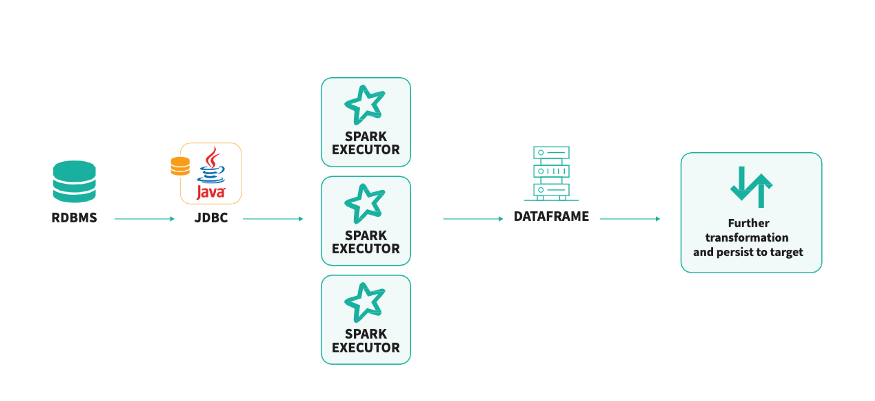

1. Crear un DataFrame procedente de una base de datos relacional

La base de datos Rfam es una colección de familias de secuencias de ARN estructurales que incluyen genes de ARN no codificantes, así como elementos cis-reguladores. Cada familia está representada por un alineamiento múltiple de secuencias y un modelo de covarianza (MC).

[Enlace](https://docs.rfam.org/en/latest/about-rfam.html)

In [18]:
df = (spark.read.format("jdbc")
.option("url","jdbc:mysql://mysql-rfam-public.ebi.ac.uk:4497/Rfam")
.option("dbtable","family")
.option("user","rfamro")
.option("password","")
.load())

In [19]:
df.show()

+--------+-------------+---------+--------------------+--------------------+--------------------+----------------+--------------+------------+--------------------+--------------------+------------------+--------------------+--------------------+--------+--------+--------------+----------+--------------------+--------------------+-----------------+--------------------+---------------+--------+------------+---------+------------+--------------+----+----+---------------+-------+----------+-------------------+-------------------+
|rfam_acc|      rfam_id|auto_wiki|         description|              author|         seed_source|gathering_cutoff|trusted_cutoff|noise_cutoff|             comment|         previous_id|           cmbuild|         cmcalibrate|            cmsearch|num_seed|num_full|num_genome_seq|num_refseq|                type|    structure_source|number_of_species|number_3d_structures|num_pseudonokts|tax_seed|ecmli_lambda| ecmli_mu|ecmli_cal_db|ecmli_cal_hits|maxl|clen|match_pair_n

Spark también permite definir la división o partición para que los datos se extraigan en paralelo de diferentes tareas generadas por los ejecutores de Spark.
* PartitionColumn es un equivalente de la opción split-by en Sqoop.

* NumPartitions también define el número máximo de conexiones JDBC "concurrentes" realizadas a las bases de datos. La conexión JDBC concurrente real podría ser inferior a este número en función del número de ejecutores de Spark disponibles para el trabajo.

* LowerBound y UpperBound definen el rango mínimo y máximo de la clave primaria, que utiliza junto con numPartitions para permitir a Spark paralelizar la extracción de datos dividiendo el rango en múltiples tareas.



In [20]:
df2 = (spark.read.format("jdbc")
.option("url","jdbc:mysql://mysql-rfam-public.ebi.ac.uk:4497/Rfam")
.option("dbtable","family")
.option("user","rfamro")
.option("password","")
.option("lowerBound", 0)
.option("upperBound",10000)
.option("numPartitions", 4)
.option("partitionColumn", "auto_wiki")
.load())


In [ ]:
df2.show()

+--------+-------------+---------+--------------------+--------------------+--------------------+----------------+--------------+------------+--------------------+--------------------+------------------+--------------------+--------------------+--------+--------+--------------+----------+--------------------+--------------------+-----------------+--------------------+---------------+--------+------------+---------+------------+--------------+----+----+---------------+-------+----------+-------------------+-------------------+
|rfam_acc|      rfam_id|auto_wiki|         description|              author|         seed_source|gathering_cutoff|trusted_cutoff|noise_cutoff|             comment|         previous_id|           cmbuild|         cmcalibrate|            cmsearch|num_seed|num_full|num_genome_seq|num_refseq|                type|    structure_source|number_of_species|number_3d_structures|num_pseudonokts|tax_seed|ecmli_lambda| ecmli_mu|ecmli_cal_db|ecmli_cal_hits|maxl|clen|match_pair_n

In [21]:
db_name = "rfam"
spark.sql(f"CREATE DATABASE IF NOT EXISTS {db_name}")
df2.write.saveAsTable("rfam.family")

In [22]:
df2.write.csv("prueba.csv")

In [23]:
!ls prueba.csv

part-00000-59ca1e2d-7a8e-45ef-9dfa-6ce080d07dec-c000.csv  _SUCCESS
part-00001-59ca1e2d-7a8e-45ef-9dfa-6ce080d07dec-c000.csv


In [24]:
!cat prueba.csv/*

RF00001,5S_rRNA,1302,5S ribosomal RNA,"Griffiths-Jones SR, Mifsud W, Gardner PP","Szymanski et al, 5S ribosomal database, PMID:11752286",38.0,38.0,37.9,"5S ribosomal RNA (5S rRNA) is a component of the large ribosomal subunit in both prokaryotes and eukaryotes. In eukaryotes, it is synthesised by RNA polymerase III (the other eukaryotic rRNAs are cleaved from a 45S precursor synthesised by RNA polymerase I). In Xenopus oocytes, it has been shown that fingers 4-7 of the nine-zinc finger transcription factor TFIIIA can bind to the central region of 5S RNA. Thus, in addition to positively regulating 5S rRNA transcription, TFIIIA also stabilises 5S rRNA until it is required for transcription.",,cmbuild -F CM SEED,cmcalibrate --mpi CM,cmsearch --cpu 4 --verbose --nohmmonly -T 24.99 -Z 549862.597050 CM SEQDB,712,139932,0,0,Gene; rRNA;,Published; PMID:11283358,8022,0,,"",0.59496,-5.32219,1600000,213632,305,119,true,-3.7812,0.71822,2013-10-03T20:41:44.000Z,2019-01-04T15:01:52.000Z
RF00002,5_8S